# The MNIST Dataset

In this notebook, we will create a neural network to recognize handwritten digits from the famous MNIST dataset.

We will experiment with two different networks for this task. The first one will be a *multi-layer perceptron* (MLP), which is a standard type of feedforward neural network with fully-connected layers of weights, and the second will be a *convolutional neural network* (CNN), which takes advantage of the inherently two-dimensional spatial geometry of the input images.

Let's begin by reading in the MNIST dataset and printing a short description of its contents.

In [1]:
import conx as cx
mnist = cx.Dataset.get('MNIST')
mnist.info()

Using Theano backend.
Conx, version 3.6.1


**Dataset**: MNIST


Original source: http://yann.lecun.com/exdb/mnist/

The MNIST dataset contains 70,000 images of handwritten digits (zero
to nine) that have been size-normalized and centered in a square grid
of pixels.  Each image is a 28 × 28 × 1 array of floating-point numbers
representing grayscale intensities ranging from 0 (black) to 1
(white).  The target data consists of one-hot binary vectors of size
10, corresponding to the digit classification categories zero through
nine.  Some example MNIST images are shown below:

![MNIST Images](https://github.com/Calysto/conx/raw/master/data/mnist_images.png)

**Information**:
   * name    : MNIST
   * length  : 70000

**Input Summary**:
   * shape  : (28, 28, 1)
   * range  : (0.0, 1.0)

**Target Summary**:
   * shape  : (10,)
   * range  : (0.0, 1.0)



We will split the 70,000 digits into a training set of 60,000 images and a testing set of 10,000 images.

In [2]:
mnist.split(10000)
mnist.summary()

_________________________________________________________________
MNIST:
Patterns    Shape                 Range                         
inputs      (28, 28, 1)           (0.0, 1.0)                    
targets     (10,)                 (0.0, 1.0)                    
Total patterns: 70000
   Training patterns: 60000
   Testing patterns: 10000
_________________________________________________________________


The training and testing images can be referenced independently, via the dataset properties `train_inputs` and `test_inputs`. The `inputs` property refers to all 70,000 input images.

In [3]:
print(len(mnist.inputs), 'total images')
print(len(mnist.train_inputs), 'images for training')
print(len(mnist.test_inputs), 'images for testing')

70000 total images
60000 images for training
10000 images for testing


Let's take a look at some individual input images.

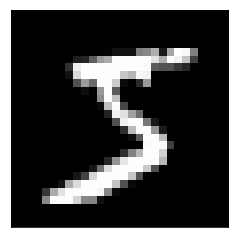

In [4]:
cx.view(mnist.train_inputs[0])  # same as mnist.inputs[0]

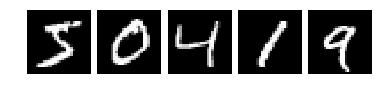

In [5]:
cx.view(mnist.train_inputs[0:5])   # same as mnist.inputs[0:5]

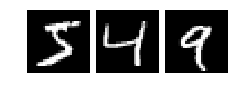

In [6]:
cx.view(mnist.train_inputs[0, 2, 4])

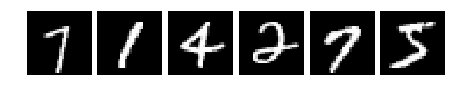

In [7]:
selected = [42, 77, 150, 16, 15, 0]
cx.view(mnist.train_inputs[selected])

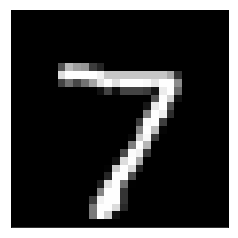

In [8]:
cx.view(mnist.test_inputs[0])

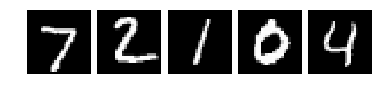

In [9]:
cx.view(mnist.test_inputs[0:5])

The dataset properties `train_targets`, `train_labels`, `test_targets`, and `test_labels` refer to the target data.

In [10]:
mnist.test_labels[0:5]

['7', '2', '1', '0', '4']

In [11]:
mnist.test_targets[0:5]

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

As another example, we could use `test_labels` to select digits of a particular category from the testing data, and then view the first twenty, as follows:

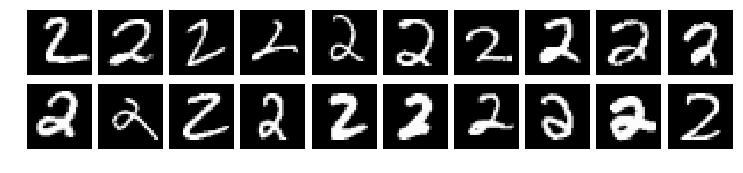

In [12]:
selected = [i for i in range(len(mnist.test_inputs)) if mnist.test_labels[i] == '2']
digits = mnist.test_inputs[selected]
cx.view(digits[:20], layout=(2,10))

We can accomplish the same thing more directly (and efficiently) using the `select` method, together with the `slice` keyword:

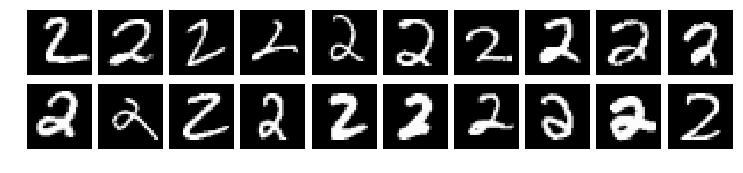

In [13]:
digits = mnist.test_inputs.select(lambda i,ds: ds.test_labels[i] == '2', slice=20)
cx.view(digits, layout=(2,10))

The MNIST digits are grayscale images, with each pixel represented as a single intensity value in the range 0 (black) to 1 (white). You can think of the whole image as consisting of 784 numbers arranged in a plane of 28 rows and 28 columns. For color (RGB) images, however, each pixel consists of three numbers (one for Red intensity, one for Green, and one for Blue). Therefore color images are represented as arrays of shape *rows* &times; *columns* &times; 3, where the 3 indicates the *depth* of the image. For consistency, the grayscale MNIST images are treated as images of depth 1, with shape *rows* &times; *columns* &times; 1. We can verify this by calling `cx.shape` on input image #0:

In [14]:
cx.shape(mnist.inputs[0])

(28, 28, 1)

## A Multi-Layer Perceptron for MNIST Classification

Our first network will have an input layer, two fully-connected hidden layers, and an output layer containing 10 output units (one for each possible digit category). Since this is a classification task, the output layer will use the *Softmax* function to generate a probability distribution of output values, where each value is a number in the range 0-1 representing the probability that the input image corresponds to that output unit's digit category.

The input layer's shape must match that of the input data, so we  declare its shape to be <tt>(28,28,1)</tt>. We then add two densely-connected hidden layers of 30 units each, both of which use the ReLU (rectified linear) activation function. However, we cannot connect the input layer directly to the first hidden layer, because the layer shapes do not match. Instead, we must first "flatten" the data before feeding it into the first hidden layer. Finally, we add an output layer of 10 units that uses the *Softmax* activation function. Here is the code that builds the network:

In [15]:
net = cx.Network("MNIST_MLP")

net.add(cx.Layer("input", (28,28,1)),
        cx.FlattenLayer("flat_input"),
        cx.Layer("hidden1", 30, activation='relu', dropout=0.20),
        cx.Layer("hidden2", 30, activation='relu', dropout=0.20),
        cx.Layer("output", 10, activation='softmax'))

# creates connections between layers in the order they were added
net.connect()

Notice that each hidden layer in the network includes a `dropout` setting of 20%. Dropout is a technique that helps to improve a network's ability to generalize what it has learned, by making it less sensitive to noise and to irrelevant correlations that may exist in the training data. During training, a randomly chosen subset of units in a dropout layer (here, 20% of the units) will be turned off (set to zero activation) on each training cycle, with different random subsets being chosen on each cycle. Dropout only occurs during training; after the network has learned, all units participate in the classification of input data. 

Finally, we need to tell the network which dataset to use.

In [16]:
net.set_dataset(mnist)

We are now ready to compile the network. To do so, we must specify the error (or "loss") function that measures the network's performance, and the specific learning algorithm for optimizing the network's weights during training. For a classification task using *Softmax*, in which the output of the network is a probability distribution across several possible classification categories, the appropriate error function is usually the *categorical crossentropy* function. The choice of optimizer is typically some variant of stochastic gradient descent. Here we will use RMSprop. After compiling the network, it is ready to be trained. The `summary()` method prints out a brief summary of each layer, including the total number of trainable parameters (weights and biases) in the network.

In [17]:
net.compile(error='categorical_crossentropy', optimizer='rmsprop')
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
flat_input (Flatten)         (None, 784)               0         
_________________________________________________________________
hidden1 (Dense)              (None, 30)                23550     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
hidden2 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
output (Dense)               (None, 10)                310       
Total para

Let's take a look at the network before we train it. The `dashboard` provides an easy-to-use graphical interface, showing the network's response to each input image in the dataset. (The small <font size="5">&#10683;</font> symbols indicate layers with dropout.)

In [18]:
dash = net.dashboard()
dash

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=0.6, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=True, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('', 'input'), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=4, options=('input', 'flat_input', 'hidden1', 'hidden2', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AANAAAK8AAAIC8wAAsAAAbwAA0AAAkPr2+vPn8wAAVkdH/7a2///X1/+YmP+Ghv+2tpaW/yYm//9nZ/8mJv9WVnh4//84OP8VFdfX/2Zm//92dlhY//9GRjU1///Fxf+mpoaG/xYW/8jI/6Wl/38AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

Clicking on **MNIST_MLP** at the top of the dashboard will open up a panel of settings for controlling the appearance and functionality of the network display. For example, to choose between the training set and testing set images, you can select "Train" or "Test" from the *Dataset* pulldown menu. 

The `propagate` method sends an input pattern through the network and returns a list of the output values. In the example below, the outputs are all around 0.1 because the network has not yet been trained. After training, one of the output values will typically be much larger than the others, corresponding to the output classification category.

In [19]:
net.propagate(mnist.train_inputs[0])

[0.07839051634073257,
 0.13194623589515686,
 0.1052803322672844,
 0.077577605843544,
 0.17349381744861603,
 0.09359003603458405,
 0.08958906680345535,
 0.07621065527200699,
 0.11846975237131119,
 0.05545198544859886]

We can visualize the weights on connections into specific units by calling `plot_layer_weights`. For example, the command below shows the weights from the input layer into units 0, 1, and 2 of the first hidden layer, displayed as 28 &times; 28 pixel array (where each "pixel" represents a weight from the input layer into a hidden unit). The `wrange` keyword specifies the minimum and maximum weight values for the color coding. Since the network has not yet been trained, the weights are all small random values close to zero.

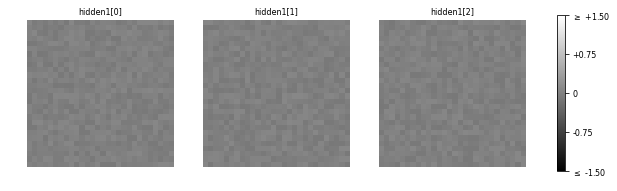

In [20]:
net.plot_layer_weights('hidden1', units=[0,1,2], vshape=(28,28), wrange=(-1.5, 1.5))

Let's train the network for 30 epochs, using a batch size of 128. This means that images from the training set will be presented to the network in batches of 128 at a time, and for each batch, the RMSprop algorithm will update the network's weights by an appropriate amount. Then another batch of 128 images will be presented, and so on, until all 60000 training images in the dataset have been processed, which constitutes one epoch of training. This entire cycle will be repeated for 30 epochs. As training proceeds, the network's error (loss) on both the training set and testing set (also called the validation set) will be shown on the left graph, and the network's accuracy will be shown on the right graph. The accuracy is simply the fraction of input images that the network classifies correctly.

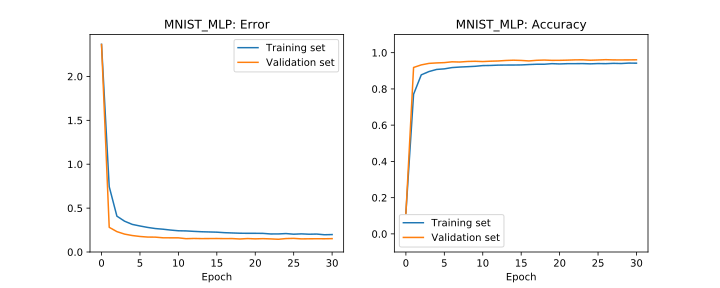

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#   30 |   0.19857 |   0.94205 |   0.15235 |   0.96070 


In [21]:
net.train(epochs=30, batch_size=128)

The detailed epoch-by-epoch training history of the network is available by calling `show_results()`. The optional `report_rate` keyword specifies which epochs to show.

In [22]:
net.show_results(report_rate=5)

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#    0 |   2.36588 |   0.11548 |   2.36324 |   0.11190 
#    5 |   0.29629 |   0.91072 |   0.17690 |   0.94510 
#   10 |   0.24182 |   0.92878 |   0.16126 |   0.95100 
#   15 |   0.22588 |   0.93238 |   0.15370 |   0.95720 
#   20 |   0.21293 |   0.93780 |   0.14976 |   0.95780 
#   25 |   0.20276 |   0.93998 |   0.15517 |   0.95970 
#   30 |   0.19857 |   0.94205 |   0.15235 |   0.96070 
#   30 |   0.19857 |   0.94205 |   0.15235 |   0.96070 


The `plot` method shows the value of various network metrics during training. The metrics `loss` and `val_loss` represent the value of the error (loss) function on the training and testing sets, respectively.  Likewise, `acc` and `val_acc` represent the accuracy of the training and testing sets, respectively. The optional `ymin` and `ymax` keywords can be used to adjust the y-axis scale. For example:

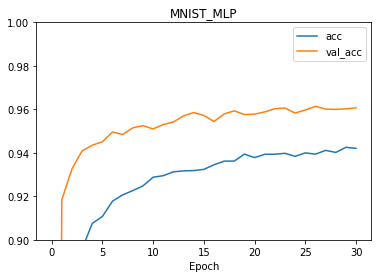

In [23]:
net.plot(['acc', 'val_acc'], ymin=0.9, ymax=1)

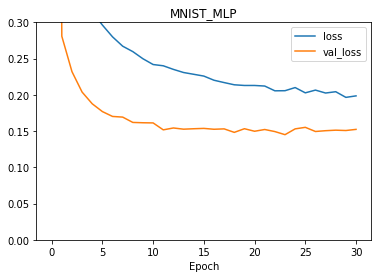

In [24]:
net.plot(['loss', 'val_loss'], ymin=0, ymax=0.3)

After training, the index of the largest output value in response to an input image corresponds to the network's digit classification. For example, test input #42 is shown below, along with the network's response.

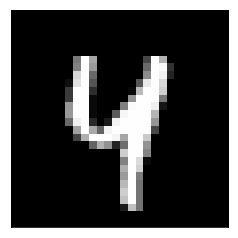

In [25]:
cx.view(net.dataset.test_inputs[42])

In [26]:
net.propagate(net.dataset.test_inputs[42])

[1.166196867603852e-15,
 8.25941121052054e-11,
 2.497051454497523e-10,
 3.1735762906492937e-09,
 0.9999774694442749,
 1.6164953819952643e-09,
 2.316500644260135e-15,
 5.632419401990774e-07,
 9.335036216251424e-11,
 2.198909714934416e-05]

In [27]:
cx.argmax(net.propagate(net.dataset.test_inputs[42]))

4

Examining the weights into the same three hidden units as before shows that these units have learned to respond in different ways to different parts of the input image.

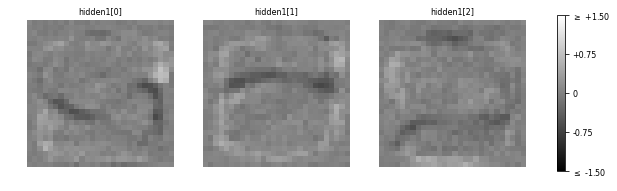

In [28]:
net.plot_layer_weights('hidden1', units=[0,1,2], vshape=(28,28), wrange=(-1.5, 1.5))

## A Convolutional Network for MNIST Classification

Convolutional neural networks (CNNs) are loosely inspired by the neurobiology of the visual system. The key idea is that each unit in a convolutional layer receives connections from a limited number of units in the previous layer (which can be thought of as the unit's "visual field"), and these connections are arranged in a two-dimensional topology to take advantage of spatial information. Each convolutional layer specifies a number of independent *features* to be learned, along with the *N*&nbsp;&times;&nbsp;*N* size of the visual field (also called the *kernel size*). The units responsible for learning a feature share connections across the entire convolutional layer, which often leads to far fewer network parameters compared to a network with fully-connected layers.

Another type of layer common to CNNs is the *pooling* layer, which reduces the amount of information flowing through the network by the process of subsampling. Each pooling unit receives input from a limited number of units in the previous layer, and then applies some function (like *maximum* or *average*) to these inputs. The overall effect is to produce a coarser-grained version of the information from the previous layer, which makes the network less sensitive to small variations in position.

We will define a CNN for MNIST classification using two convolutional layers with 5 &times; 5 kernels, each followed by a pooling layer with 2 &times; 2 kernels that compute the maximum of their inputs. The first convolutional layer will learn 16 relatively low-level features, whereas the second will learn 32 higher-level features. These features will then feed into a hidden layer (after being flattened), followed by an output classification layer using *Softmax*.

In [29]:
cnn = cx.Network("MNIST_CNN")

cnn.add(cx.Layer("input", (28,28,1), colormap="gray"),
        cx.Conv2DLayer("conv2D_1", 16, (5,5), activation="relu", dropout=0.2),
        cx.MaxPool2DLayer("maxpool1", (2,2)),
        cx.Conv2DLayer("conv2D_2", 32, (5,5), activation="relu", dropout=0.2),
        cx.MaxPool2DLayer("maxpool2", (2,2)),
        cx.FlattenLayer("flat"),
        cx.Layer("hidden", 30, activation='relu'),
        cx.Layer("output", 10, activation='softmax'))

cnn.connect()

In [30]:
cnn.dataset.get("MNIST")
cnn.dataset.split(10000)
cnn.dataset.summary()

_________________________________________________________________
MNIST:
Patterns    Shape                 Range                         
inputs      (28, 28, 1)           (0.0, 1.0)                    
targets     (10,)                 (0.0, 1.0)                    
Total patterns: 70000
   Training patterns: 60000
   Testing patterns: 10000
_________________________________________________________________


In [31]:
cnn.compile(error='categorical_crossentropy', optimizer='rmsprop')

In [32]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 12, 12, 16)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 8, 8, 32)          12832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 4, 4, 32)          0         
__________

<img src="mnist-cnn.png" width="80%">

In [33]:
cnn.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', options=('Test', 'Train'), rows=1, value='Test'), FloatSlider(value=1.0, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=True, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', index=2, options=('', 'input', 'conv2D_1', 'maxpool1', 'conv2D_2', 'maxpool2'), rows=1, value='conv2D_1'), IntText(value=8, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=4.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=7, options=('input', 'conv2D_1', 'maxpool1', 'conv2D_2', 'maxpool2', 'flat', 'hidden', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AANAAAK8AAAIC8wAAsAAAbwAA0AAAkPr2+vPn8wAAVkdH/7a2///X1/+YmP+Ghv+2tpaW/yYm//9nZ/8mJv9WVnh4//84OP8VFdfX/2Zm//92dlhY//9GRjU1///Fxf+mpoaG/xYW/8jI/6Wl/38AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

Training our CNN will take some time, so the first time we execute the code below, the network's state will be saved. This way, the next time the code is executed, we won't have to wait for the network to retrain. Calling `cnn.delete()` will delete the saved state.

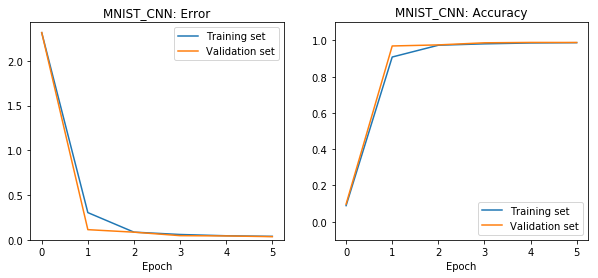

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#    0 |   2.31498 |   0.08858 |   2.31602 |   0.09680 
#    1 |   0.30398 |   0.90873 |   0.11336 |   0.96970 
#    2 |   0.08558 |   0.97377 |   0.08525 |   0.97560 
#    3 |   0.05925 |   0.98148 |   0.04633 |   0.98720 
#    4 |   0.04513 |   0.98627 |   0.04313 |   0.98920 
#    5 |   0.03857 |   0.98787 |   0.03517 |   0.98890 
#    5 |   0.03857 |   0.98787 |   0.03517 |   0.98890 


In [34]:
if not cnn.saved():
    cnn.train(epochs=5, batch_size=128)
    cnn.save()
else:
    cnn.load()
    cnn.plot_results()
    cnn.show_results()